In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import IndexSlice as ix
from typing import List
from copy import deepcopy
from tqdm.auto import tqdm
from pathlib import Path
from IPython.display import display, display_markdown

import yfinance
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [2]:
# constants
TARGET = "N225"
TICKERS = {
    "^N225": "Nikkei 225",
    "^GSPC": "S&P 500",
    "^TNX": "US10Y Interest Rate",
    "DX-Y.NYB": "ICE Dollar Index",
    "^VIX": "VIX",
}

TRAIN_ST = "2011-01-01"
TRAIN_ET = "2016-12-30"
VALID_ST = "2017-01-01"
VALID_ET = "2017-12-30"
TEST_ST = "2018-01-01"
TEST_ET = "2023-12-30"

# 1. Data
---

We utilize daily OHLCV data obtained from Yahoo Finance for both features and labels in our learning and evaluation processes.   
The data is acquired using the `yfinance` API and covers the period from January 2010 to December 2023.

Our target for prediction is the fluctuation of the Nikkei 225 Index, a prominent stock index in Japan.   
In addition to the Nikkei 225, the data used for features includes the Dollar Index, S&P 500 Index, VIX Index, and the U.S. 10-year yield data.   

The pricing of Japanese stocks is influenced by the performance of U.S. stocks. Therefore, we have incorporated the S&P 500 Index as it represents the U.S. stock market.   
Furthermore, to include information about the implied volatility of U.S. stocks and to allow the model to discern between periods of financial easing and risk-on/off market conditions, we have added the VIX Index, Dollar Index, and U.S. yield data.  

Table 1 provides the data acquisition periods and the number of data points for each ticker.

In [3]:
# Get Daily OHLC from YFinance
if not Path("data.csv").exists():
    from cqf.data.yfinance import get_daily_ohlc
    ohlc = pd.concat([get_daily_ohlc(ticker).assign(ticker=tickname) for ticker, tickname in TICKERS.items()])
else:
    ohlc = pd.read_csv("data.csv", index_col=["date"], parse_dates=["date"])

display(
    "Table1: Feature Tickers List",
    pd.DataFrame([TICKERS]).T.reset_index().set_axis(["YFinance Ticker", "Name"], axis=1),
    
    "Table2: Raw Data Sample Periods",
    ohlc.reset_index().groupby("ticker").date.agg(["min", "max", "count"]).rename(TICKERS)
)

'Table1: Feature Tickers List'

,YFinance Ticker,Name
0,^N225,Nikkei 225
1,^GSPC,S&P 500
2,^TNX,US10Y Interest Rate
3,DX-Y.NYB,ICE Dollar Index
4,^VIX,VIX


'Table2: Raw Data Sample Periods'

,min,max,count
ticker,,,
ICE Dollar Index,2010-01-04,2023-12-29,3521
Nikkei 225,2010-01-04,2023-12-29,3425
S&P 500,2010-01-04,2023-12-29,3522
US10Y Interest Rate,2010-01-04,2023-12-29,3519
VIX,2010-01-04,2023-12-29,3522


# 2. Features and Labels
---

## 2.1 Features

We create features from the Daily OHLCV data for each ticker.  
For this study, we have generated four distinct features: $𝑂𝐶$, $𝐻𝐿$, $𝑂𝑆$("Overshoot"), and $V$.  

All of these features can be defined solely based on information available at date $𝑡$.
$𝑂𝐶$ represents the magnitude of price change at date $𝑡$, while $𝐻𝐿$ expresses the volatility at date $𝑡$. 
$𝑂𝑆$ ("Overshoot") measures the deviation from Open/Close to High/Low at date $𝑡$, indicating situations where, for example, a significant positive value suggests an attempt to breach the upper limit but was met with resistance.  

$𝑉$, on the other hand, utilizes the Volume information as is.   
For variables like Dollar Index where Volume information is unavailable, it is filled with zeros.  

By creating the four features for each of the five tickers, we obtain a total of 20 distinct features.  

$$
{OC}_{Ticker}(t) := \frac{{Close}_{Ticker}(t) - {Open}_{Ticker}(t)} {{Open}_{Ticker}(t)}  \tag{F1}
$$

$$
{HL}_{Ticker}(t) := \frac{{High}_{Ticker}(t) - {Low}_{Ticker}(t)} {{Open}_{Ticker}(t)}  \tag{F2}
$$

$$
OS_{Ticker}(t) := OS_{Ticker}^{Up}(t) - OS_{Ticker}^{Down}(t)  \tag{F3} \\
$$

\begin{equation*}
where
\left\{ \,
    \begin{aligned}
    & {OS}_{Ticker}^{Up}(t) := {High}_{Ticker}(t) - \text{max} ({Open}_{Ticker}(t), {High}_{Ticker}(t)) \\
    & {OS}_{Ticker}^{Down}(t) := {Low}_{Ticker}(t) - \text{min}({Open}_{Ticker}(t), {High}_{Ticker}(t))
    \end{aligned}
\right.
\end{equation*}

$$
{V}_{Ticker}(t) := {Volume}_{Ticker}(t) \tag{F4}
$$

In [4]:
# calculate features
from cqf.preprocess.feature import calc_ohlcv_features
features = pd.concat([calc_ohlcv_features(ohlc.query("ticker==@ticker")) for ticker in ohlc.ticker.unique()], axis=1)
features_stack = (
    features
    .stack().rename("value").reset_index()
    .assign(
        ticker=lambda x: x.feature.str.split("_").str[-1].replace(TICKERS), 
        feature=lambda x: x.feature.str.split("_").str[0]
    )
    .set_index(["date", "ticker", "feature"]).value.unstack(level=[1, 2])
)

display(
    "Sample Feature Data:",
    features_stack.head(3),
)

'Sample Feature Data:'

ticker     Nikkei 225                                    S&P 500            \
feature            OC        HL        OS            V        OC        HL   
date                                                                         
2010-01-04   0.004284  0.008139  0.003629  104400000.0  0.014715  0.015503   
2010-01-05  -0.003509  0.012638  0.004230  166200000.0  0.003408  0.006154   
2010-01-06   0.002045  0.010032 -0.001048  181800000.0  0.001259  0.004614   

ticker                             US10Y Interest Rate                      \
feature           OS             V                  OC        HL        OS   
date                                                                         
2010-01-04  0.000788  3.991400e+09           -0.004664  0.013216 -0.008551   
2010-01-05 -0.002552  2.491020e+09           -0.009235  0.013456  0.001055   
2010-01-06  0.000255  4.972660e+09            0.009812  0.020154  0.005038   

ticker          ICE Dollar Index                                VIX            \
feature       V               OC        HL        OS    V        OC        HL   
date                                                                            
2010-01-04  0.0        -0.005133  0.011934 -0.000128  0.0 -0.075646  0.076107   
2010-01-05  0.0         0.003231  0.008013 -0.002456  0.0 -0.034913  0.039401   
2010-01-06  0.0        -0.002061  0.008242  0.002833  0.0 -0.021950  0.046452   

ticker                     
feature           OS    V  
date                       
2010-01-04 -0.000461  0.0  
2010-01-05  0.003491  0.0  
2010-01-06 -0.015314  0.0

## 2.2 Labeling

We aim to predict whether the $Close$ price of Nikkei 225 for the next day will be higher or lower than the $Open$ price (L1).   
To create a binary classification model, we need to convert (L1) into binary values.   
We define the threshold $\theta_{positive}$ using the median of (L1) in training sample.   
This approach ensures that the occurrence probabilities of labels (0, 1) are balanced in the training samples.  
As shown in Fig.2, $Label(t)$ distribute equaly in training sample.  

$$
{Return}_{N225}(t) := \frac{{Close}_{N225}(t+1) - {Open}_{N225}(t+1)} {{Open}_{N225}(t+1)}  \tag{L1}
$$

\begin{equation}
Label(t) :=
\left\{ \,
    \begin{aligned}
    & 1 \ (Return_{N225}(t) > \theta_{positive}) \\
    & 0 \ (Return_{N225}(t) \leq \theta_{positive})
    \end{aligned}
\right.
\tag{L2}
\end{equation}

'Fig.2: Frequency of training sample labels'

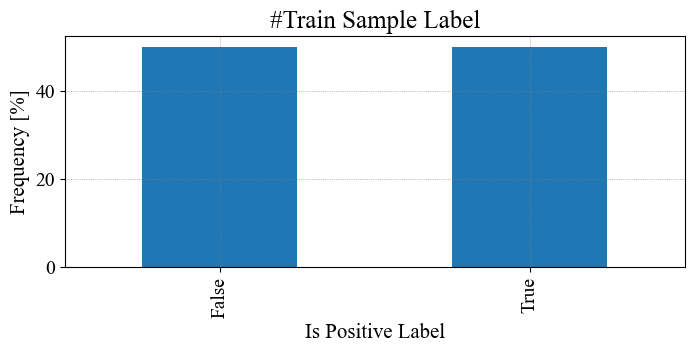

In [5]:
# basis point return of next Open to Close
label_ret = ohlc.query("ticker=='Nikkei 225'").assign(oc = lambda x: (x.close-x.open) / x.open * 1e4)["oc"].shift(-1).dropna()
# calculate positive label threshold
positive_threshold = label_ret.loc[TRAIN_ST:TRAIN_ET].median()
train_label_counts = (label_ret.loc[TRAIN_ST:TRAIN_ET] > positive_threshold).value_counts() / label_ret.loc[TRAIN_ST:TRAIN_ET].shape[0] * 100

display("Fig.2: Frequency of training sample labels")
train_label_counts.plot.bar(figsize=(8, 3), ylabel="Frequency [%]", xlabel="Is Positive Label", title="#Train Sample Label", );

# 3. EDA
---

## 3.1 Univariate statistics

### 3.1.1 Distribution

We have illustrated the distribution of each feature in Table3. Features like $OC$ and $OS$ are normalized with respect to $Open(t)$,  
resulting in values within the range of -1 to +1.   
On the other hand, features $V$ and $HL$ inherently possess values greater than or equal to 0 due to their definitions.

In [6]:
display(
    "Table3: Basic Statistics of Raw Feature Values",
    features_stack.describe().T.style.format(precision=2),
)

'Table3: Basic Statistics of Raw Feature Values'

### 3.1.2 Auto correlation

In Figure 4, we have provided a graph illustrating autocorrelation, using Nikkei 225 as an example.   
It's important to note that each feature at time 𝑡 is constructed solely from information available at time $𝑡$.

Features like $OC$ and $OS$ exhibit minimal correlation through lags.   
On the other hand, $HL$ and $V$ display a gradually decaying positive correlation.   
This behavior is believed to reflect the tendency of Volatility Clustering, where periods of high volatility tend to be followed by other high-volatility periods, and periods of low volatility are followed by other low-volatility periods.

'Fig.4: Autocorrelation of Nikkei225 Features'

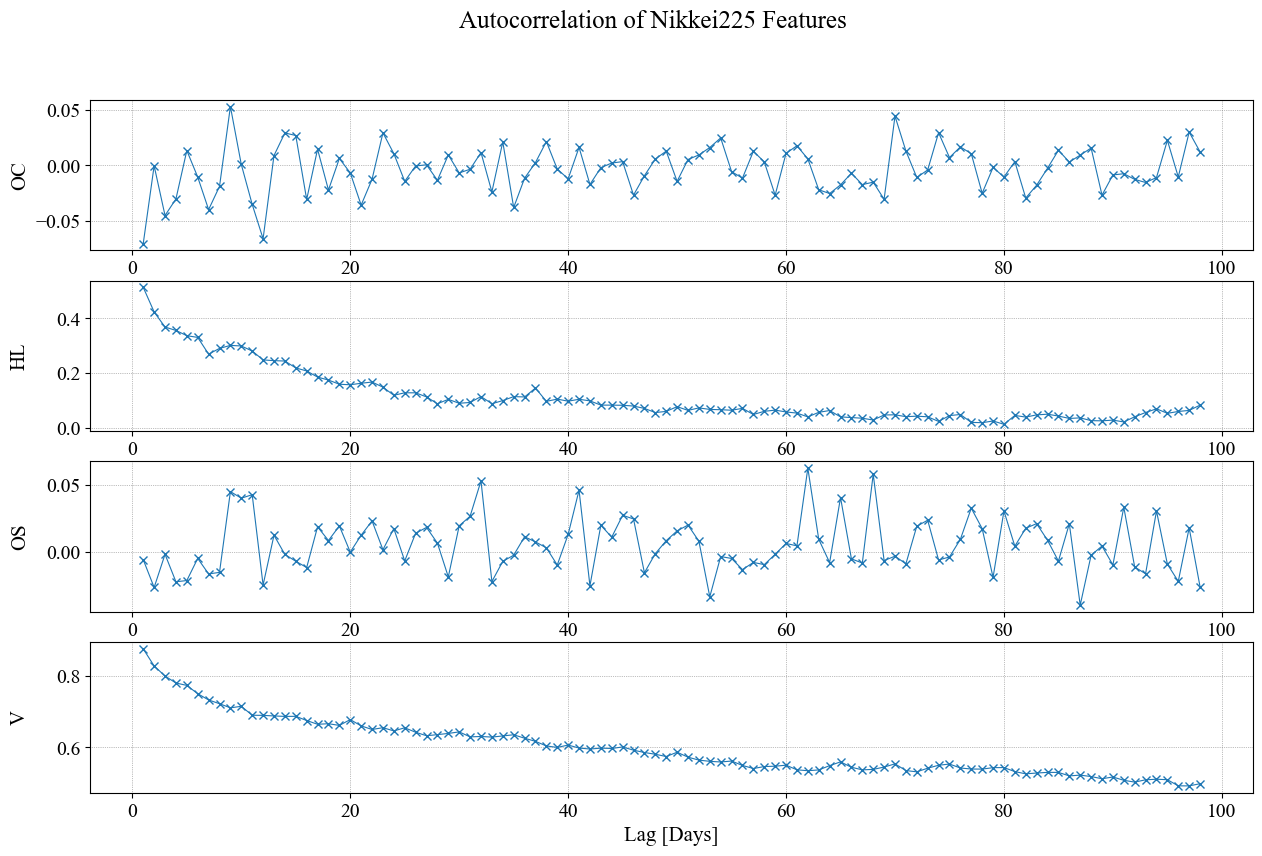

In [7]:
f = features_stack["Nikkei 225"]
fig, ax = plt.subplots(4, 1, figsize=(15, 9))
for i, feature_name in enumerate(f.columns):
    pd.Series([f[feature_name].autocorr(lag=n) for n in range(1, 100)]).shift().dropna().plot(ax=ax[i], marker="x", ylabel=feature_name)
    ax[i].set_xlabel("Lag [Days]")

display("Fig.4: Autocorrelation of Nikkei225 Features")
fig.suptitle("Autocorrelation of Nikkei225 Features")
fig.align_ylabels()

## 3.2 Multivariate statistics

Figure 5 represents the correlation matrix among the features at the same time points.   
The correlations between the individual features generally remain low, falling within the range of -0.3 to 0.3, indicating successful feature diversification.

Within each ticker, a relatively strong positive correlation is observed between $HL$ and $V$ (>0.6), indicating that periods with significant trading volume tend to experience larger price fluctuations.  

In [8]:
# Correlation matrix
display(
    "Fig.4: Correlation Matrix of Raw Feature Values",
    features_stack.corr()
    .replace(1, np.nan).style.format(precision=2).background_gradient(vmin=-1, vmax=1, cmap="RdBu")
)

'Fig.4: Correlation Matrix of Raw Feature Values'

Figure 5 displays the scatterplot matrix among the features using Nikkei 225 as an example.  
The range of $OC$ is inherently constrained by $HL$, which leads to the observation that $|OC| < HL$, reflecting the relationship between $OC$ and $HL$.

'Fig.5: Scatter Matrix of Features of Nikkei 225'

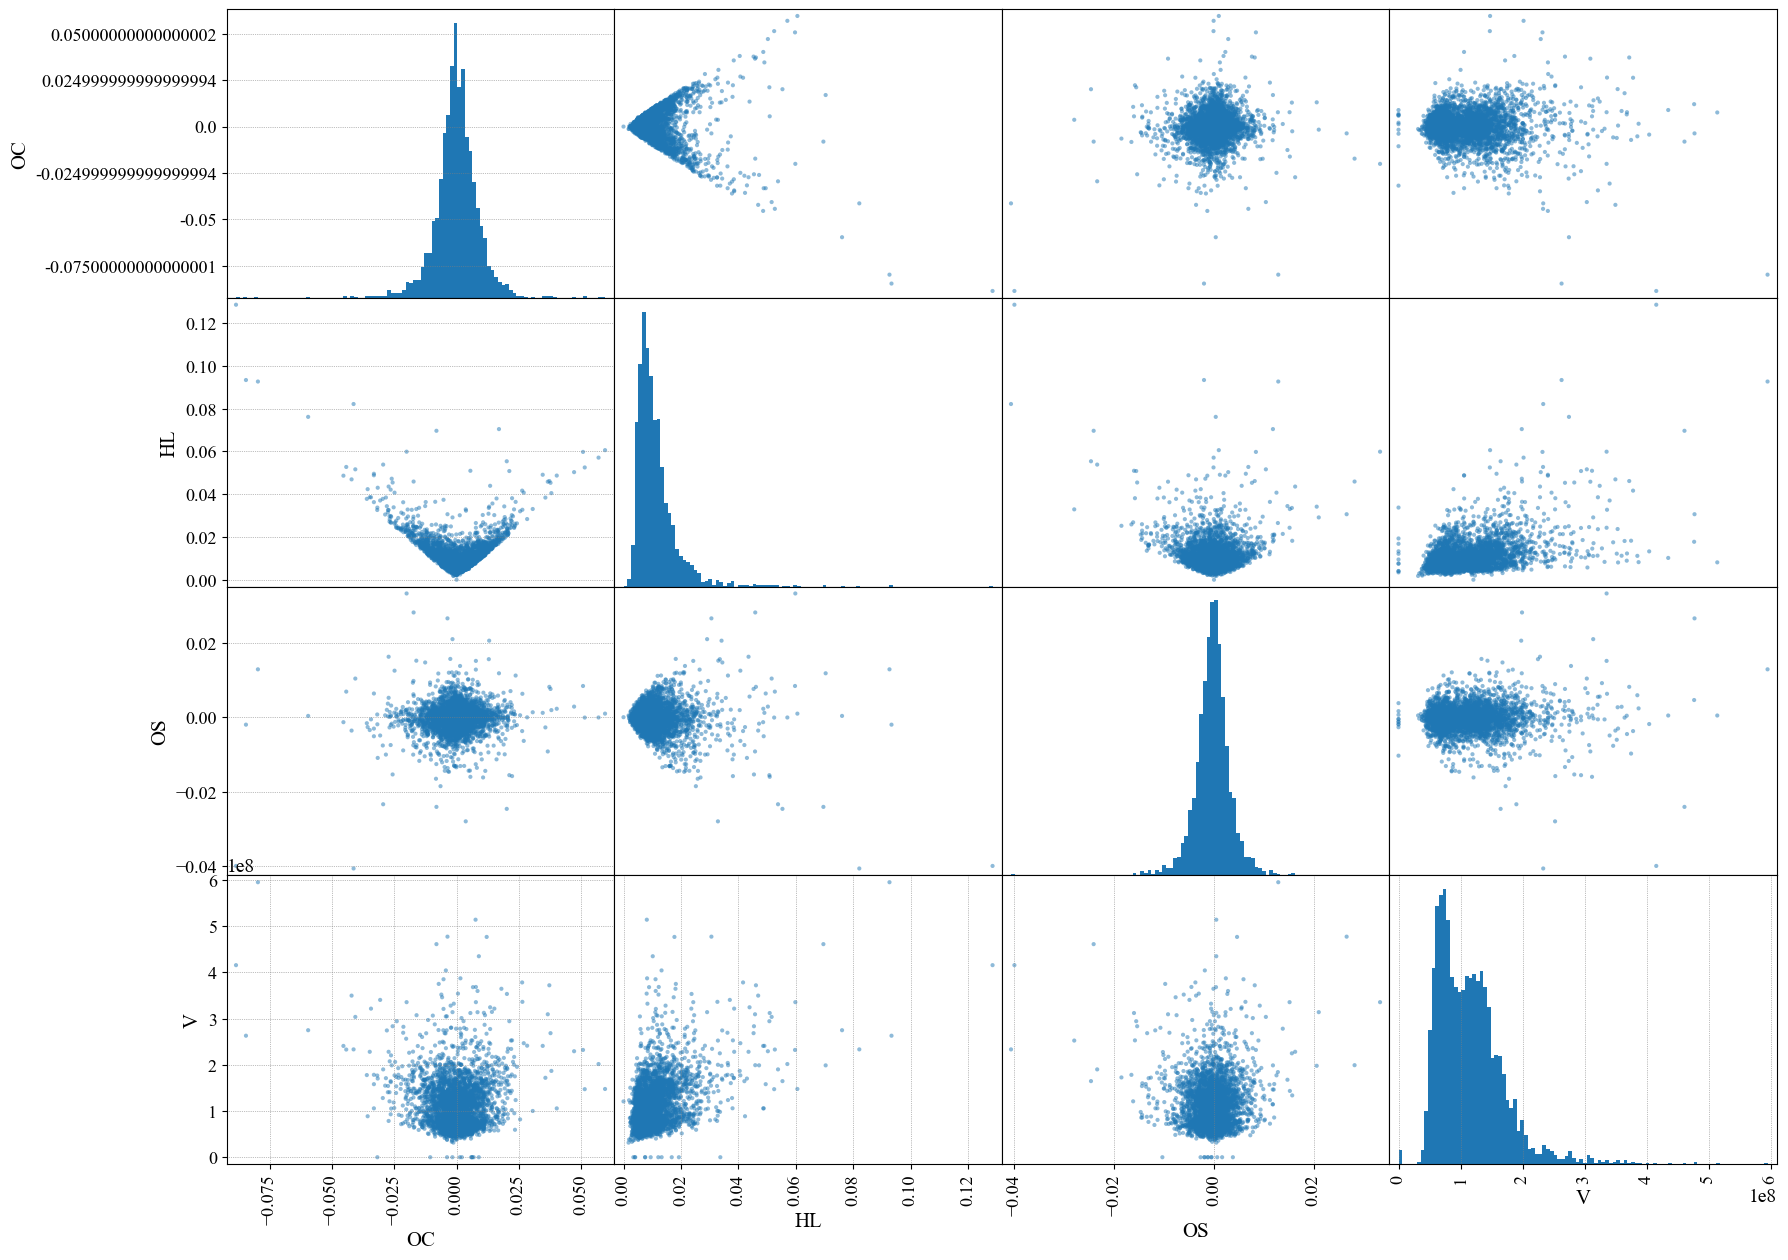

In [9]:
# Scatter matrix
display("Fig.5: Scatter Matrix of Features of Nikkei 225")

features_n225 = features_stack["Nikkei 225"]
scatter_matrix = pd.plotting.scatter_matrix(features_n225, hist_kwds={"bins": 100}, figsize=(20, 15), grid=True);
for ax in scatter_matrix.ravel():
    ax.tick_params(axis='both', labelsize=13)

# 4. Feature Transformation
---

## 4.1 Log rolling normalization

Neural Networks require input features to have a certain level of normality.  
To meet this requirement, a transformation(T1) was applied to feature set.

Firstly, a logarithmic transformation was performed to mitigate the fat tail.   
Subsequently, the values were scaled to have a mean of 0 and a variance of 1 using the mean and variance of the most recent $Ndays(=90)$ samples.

The distributions of the values after applying transformation (T1) to each feature, as well as the scatterplot matrix, are presented in Table4 and Fig.5, respectively.   
Overall, the transformed values are approximately centered around a mean of 0 and have a variance of 1.

However, note for $HL$, the median is positioned negatively, indicating that this feature does not entirely meet the normality requirement at this specific point.

\begin{equation}
    \begin{aligned}
    & LogFeature(t) = \text{log}(1 + Feature(t)) \\
    & RollingNormalizedLogFeature^{Ndays}(t) = 
        \frac 
            { LogFeature(t) - \mathbb{E}(LogFeature(s) \mid s \in [t-Ndays, t]) }
            { \sqrt{\mathbb{V} (LogFeature(s) \mid s \in [t-Ndays, t]))} }
    \end{aligned}
\tag{T1}
\end{equation}

In [10]:
# Apply transformation
from cqf.preprocess import apply_rolling_lognormalize2
features1 = apply_rolling_lognormalize2(features_stack.loc[:, ix[:, ["OC", "OS"]]])
features2 = apply_rolling_lognormalize2(features_stack.loc[:, ix[:, ["V", "HL"]]])
features_norm = pd.concat([features1, features2], axis=1).fillna(0)

In [11]:
display(
    "Table4: Basic statistics of log rolling normalized features:",
    features_norm.describe().T.sort_index().style.format(precision=2)
)

'Table4: Basic statistics of log rolling normalized features:'

'Fig.5: Scatter Matrix of Normalized Features of Nikkei 225'

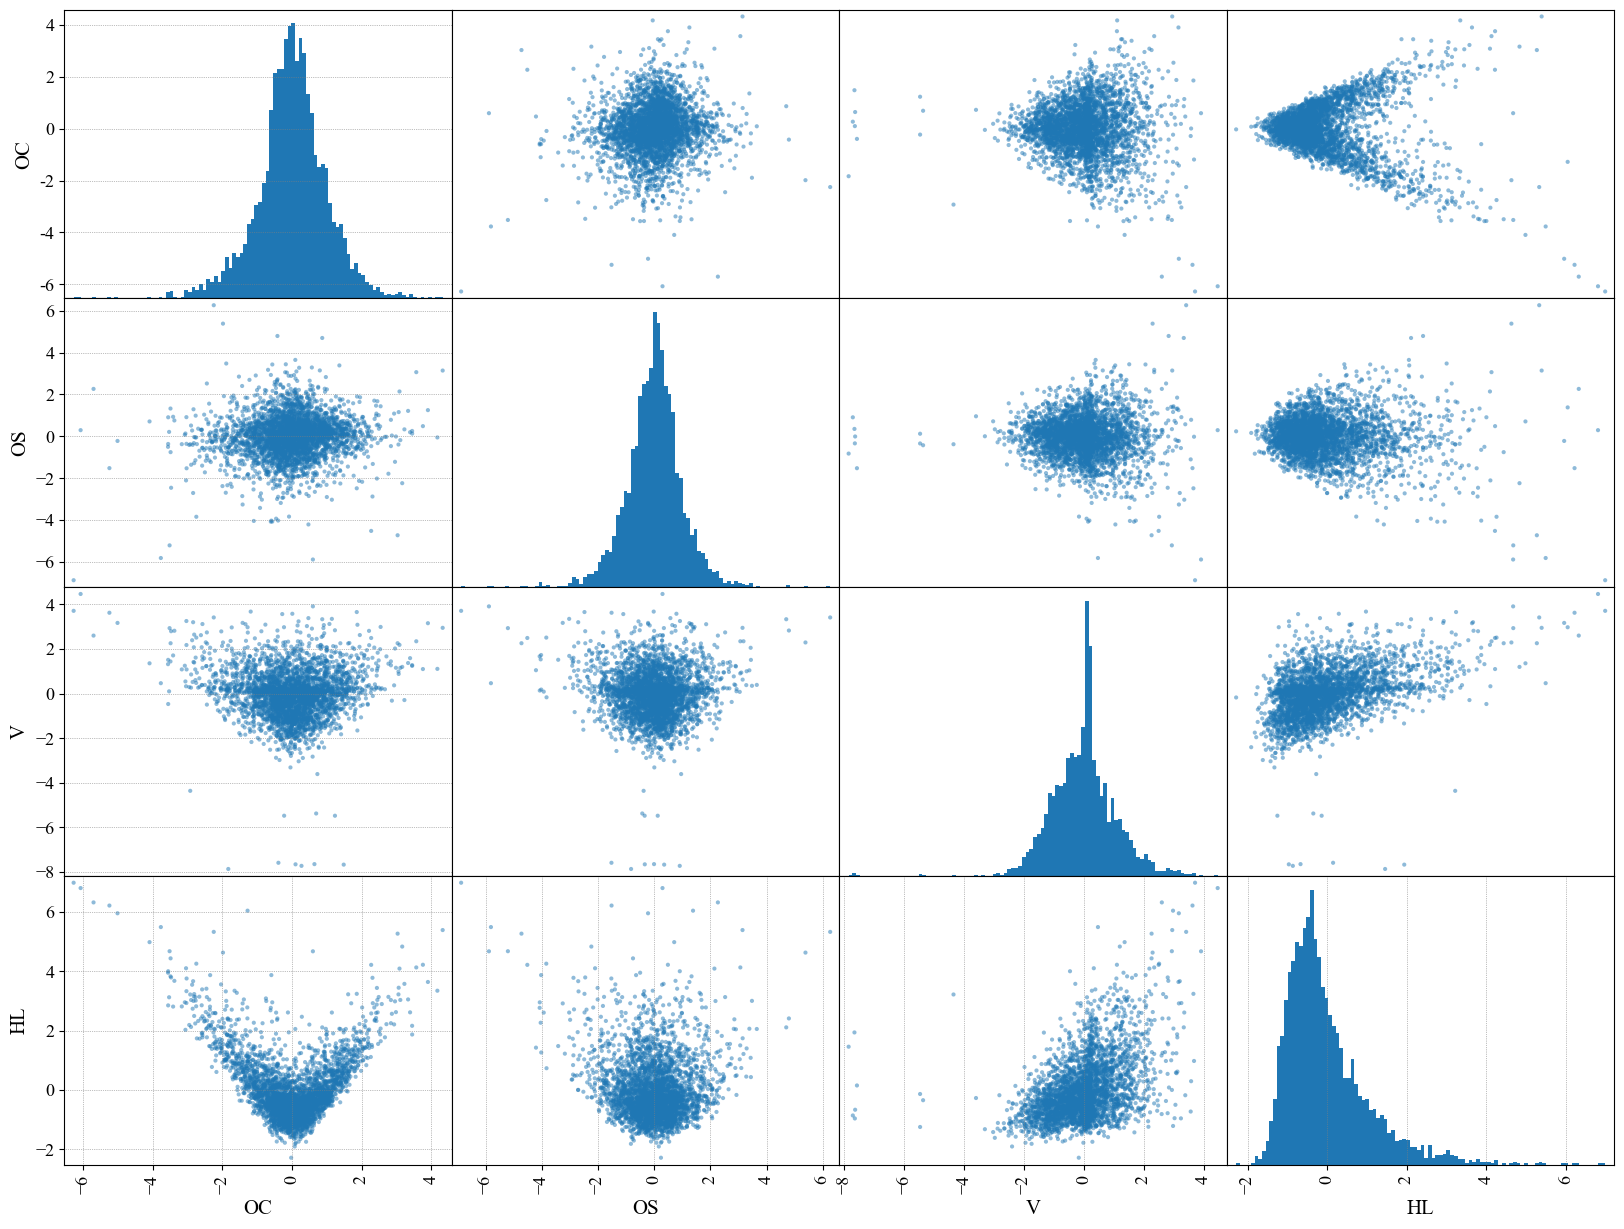

In [12]:
# Scatter matrix
display("Fig.5: Scatter Matrix of Normalized Features of Nikkei 225")

f = features_norm.loc[label_ret.index, "Nikkei 225"]
scatter_matrix = pd.plotting.scatter_matrix(f, hist_kwds={"bins": 100}, figsize=(20, 15), grid=True);
for ax in scatter_matrix.ravel():
    ax.tick_params(axis='both', labelsize=13)

# 5. Train
---

## 5.1 Train, validation and test sample splitting

Table5 shows periods of each dataset.  
To prevent forward-looking bias, each set of samples for training, validation, and testing retains the time series structure.  
Specifically, each set is provided with data spanning the following time periods:

1. Training Set: 6 years of data.
2. Validation Set: 1 year of data.
3. Test Set: 6 years of data.

This approach ensures that the model is trained, validated, and tested on temporally consistent data, helping to avoid any temporal leakage or lookahead bias.

In [13]:
display(
    "Table5. Periods of each sample",
    pd.DataFrame({
        "Train": pd.to_datetime([TRAIN_ST, TRAIN_ET]),
        "Validation": pd.to_datetime([VALID_ST, VALID_ET]),
        "Test": pd.to_datetime([TEST_ST, TEST_ET]),
    }).set_axis(["Start", "End"]).T.assign(Lentgh=lambda x: (x.End-x.Start))
)

'Table5. Periods of each sample'

,Start,End,Lentgh
Train,2011-01-01,2016-12-30,2190 days
Validation,2017-01-01,2017-12-30,363 days
Test,2018-01-01,2023-12-30,2189 days


In [14]:
# Train/test split
# Process Pandas DataFrame
y = label_ret > positive_threshold
x = features_norm.loc[y.index]
y_train = y.loc[TRAIN_ST:TRAIN_ET]
x_train = x.loc[TRAIN_ST:TRAIN_ET]
y_valid = y.loc[VALID_ST:VALID_ET]
x_valid = x.loc[VALID_ST:VALID_ET]
y_test = y.loc[TEST_ST:TEST_ET]
x_test = x.loc[TEST_ST:TEST_ET]

# Prepare Pytorch Dataset / DataLoader from x, y
from cqf.model.dataset import TimeSeriesDataset1D
def prepare_dataloader(n_lookback: int = 30, batch_size: int = 64) -> List[DataLoader]:
    train_dataset = TimeSeriesDataset1D(x=x_train, y=y_train, n_lookback=n_lookback)
    valid_dataset = TimeSeriesDataset1D(x=x_valid, y=y_valid, n_lookback=n_lookback)
    test_dataset = TimeSeriesDataset1D(x=x_test, y=y_test, n_lookback=n_lookback)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    return [train_loader, valid_loader, test_loader]

## 5.2 Run trainning loop

In this experiment, we have created a simple LSTM model for binary classification of Nikkei 225's upward and downward movements using time series features.   
The model architecture involves using the output of `torch.nn.LSTM` and combining it with an FC (Fully Connected) layer to transform it into binary classification output using Sigmoid activation.

The optimizer and loss function are fixed with the following values:  
- Optimizer: Adam
- Learning Rate: 0.0001 (fixed)
- Criterion: Binary Cross Entropy
- Batch size: 64

In [15]:
from cqf.model.lstm import LSTMClassifier
print(LSTMClassifier(input_size=30, hidden_size=32, num_layers=3))

LSTMClassifier(
  (lstm): LSTM(30, 32, num_layers=3, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In the parameter tuning process, you will focus on adjusting the following three parameters:

- `n_lookback`: The number of past days' data required for a single inference.
- `hidden_size`: The dimension of the LSTM hidden state.
- `num_layers`: The number of LSTM layers.  

`n_lookback` controls length of the timeseries, while `hidden_size` and `num_layers` control model complexity.  
Search target grid is in `param_grid` below:

In [16]:
param_grid = {"n_lookback": [5, 20, 40], "hidden_size": [16, 32], "num_layers": [1, 3, 6]}
display(f"Parameter Grid: {param_grid}")

"Parameter Grid: {'n_lookback': [5, 20, 40], 'hidden_size': [16, 32], 'num_layers': [1, 3, 6]}"

In [17]:
# Main process for model training.
from cqf.utils import to_hash
from cqf.model.utils import build_inference, run_train, set_seed
from cqf.model.lstm import LSTMClassifier
from cqf.evaluation.metrics import prediction_summary, calc_annu_sharpe
def run_lstm_train_loop(
    n_epochs = 100,
    n_lookback = 30,
    hidden_size = 32,
    num_layers = 3,
    seed = 7,
) -> pd.DataFrame:
    """ Run LSTMClassifer train loop with given parameters.
    """
    set_seed(seed)
    # Check past run and skip if exists
    params = {"epoch": n_epochs, "hidden_size": hidden_size, "n_lookback": n_lookback, "num_layers": num_layers, "seed": seed}
    hash_code = to_hash(params)
    metrics_path = Path("artifacts").joinpath(f"metrics_{hash_code}.csv")
    metrics_path.parent.mkdir(parents=True, exist_ok=True)
    if metrics_path.exists():
        return pd.read_csv(metrics_path)
        
    # Data & Model setup
    train_loader, valid_loader, _ = prepare_dataloader(n_lookback=n_lookback)
    model = LSTMClassifier(
        input_size = x.shape[1],
        hidden_size = hidden_size,
        num_layers = num_layers,
    )
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    
    # Train & Evaluation loop
    metric_log = []
    for epoch in range(n_epochs):
        run_train(model, optimizer=optimizer, criterion=criterion, train_loader=train_loader)
        if epoch % 5 == 0:
            pred_train = build_inference(model, train_loader, label_ret)
            pred_valid = build_inference(model, valid_loader, label_ret)
            metric_log.append(prediction_summary(pred_train).assign(epoch=epoch, sample_type="train"))
            metric_log.append(prediction_summary(pred_valid).assign(epoch=epoch, sample_type="valid"))
            params.update(epoch=epoch)
            model_path = Path("artifacts").joinpath(f"model_{to_hash(params)}.pth")
            torch.save(model, model_path)

    metric_log = pd.concat(metric_log)
    metric_log.to_csv(metrics_path, index=False)
    return metric_log

In [18]:
# Run on parame grid
from sklearn.model_selection import ParameterGrid
metric_log = pd.DataFrame()
for params in tqdm(ParameterGrid(param_grid)):
    metric_log = metric_log.append(run_lstm_train_loop(**params).assign(**params))

  0%|          | 0/18 [00:00<?, ?it/s]

# 6. Evaluation
---

## 6.1 In-sample evaluation and model selection

Figure 6 displays the evolution of metrics per epoch for a specific parameter setting.   
Among these metrics, `up_signal_ratio` represents the proportion of upward prediction labels made by the model.   
It is evident that at the beginning of the training, this ratio is approximately 0%. However, in the actual labels, the ratio is 50%.   
Therefore, to ensure that the models are sufficiently trained, model selection will be conducted with the constraint that "up_signal_ratio" falls within the range of 0.45 to 0.55 during evaluation.

'Fig.6: Training curve example (num_layers=1, hidden_size=32, n_lookback=40)'

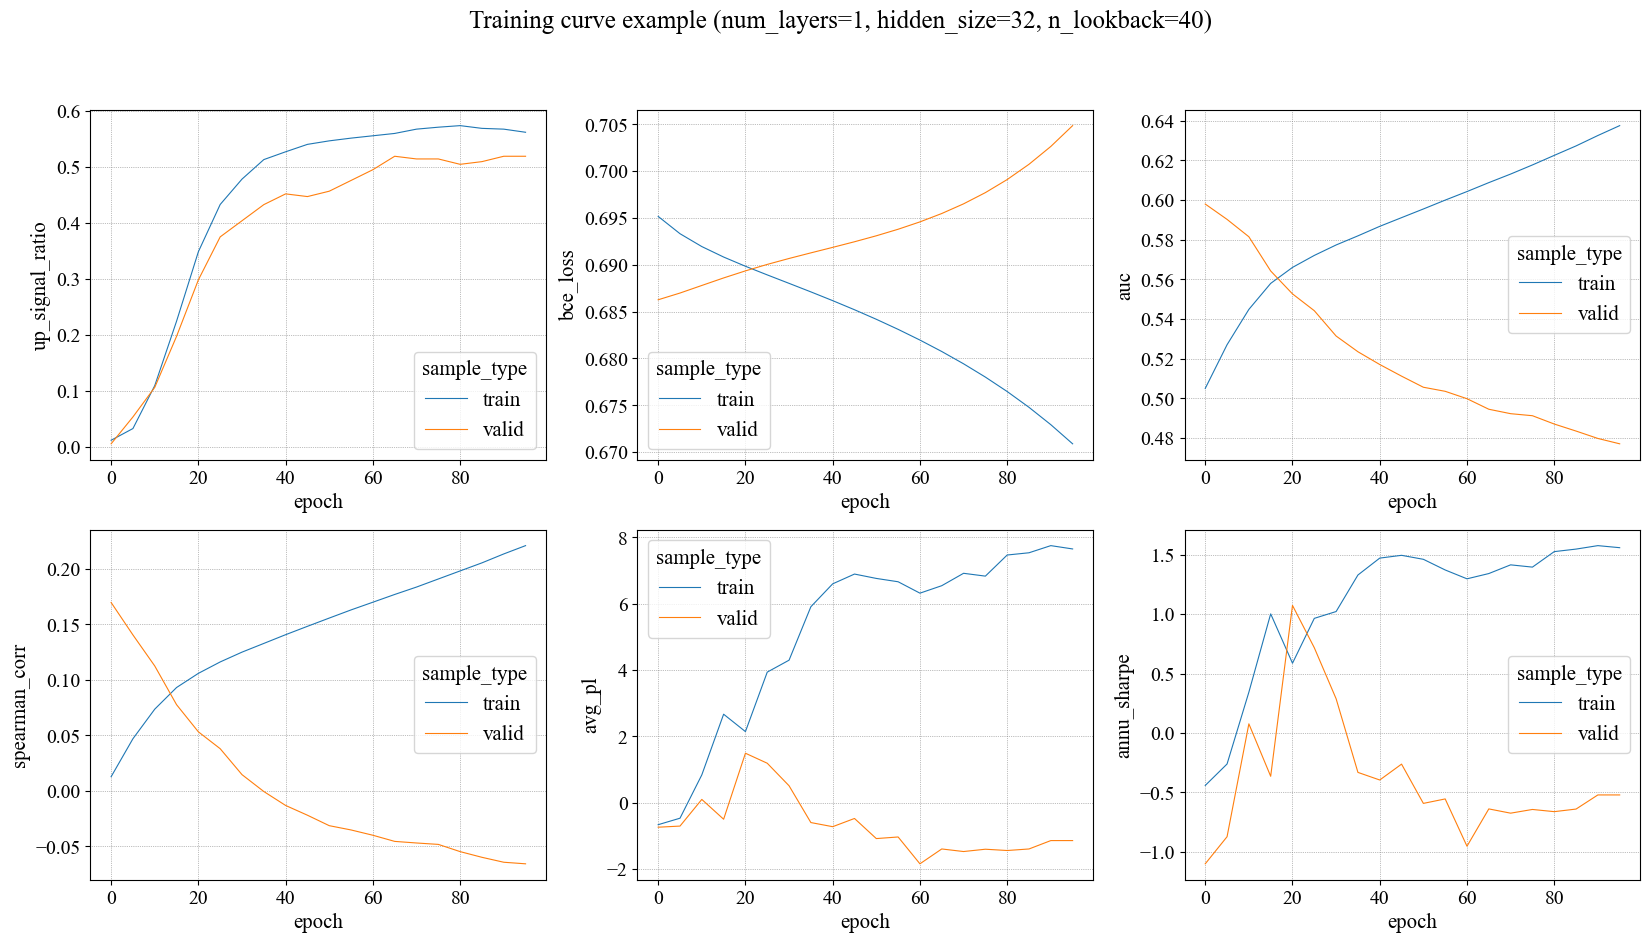

In [19]:
# Training Curve Example
metric_list = ["up_signal_ratio", "bce_loss", "auc", "spearman_corr", "avg_pl", "annu_sharpe"]
fig, ax = plt.subplots(2, len(metric_list)//2, figsize=(20, 10))
ax = ax.reshape(-1,)

display("Fig.6: Training curve example (num_layers=1, hidden_size=32, n_lookback=40)")
fig.suptitle("Training curve example (num_layers=1, hidden_size=32, n_lookback=40)")
for i, metric in enumerate(metric_list):
    (
        metric_log
        .query("num_layers==1 and hidden_size==32 and n_lookback==40")
        .set_index(["epoch", "sample_type"])[metric].unstack(level=-1).plot(ax=ax[i], ylabel=metric)
    )

During training, Binary Cross-Entropy (BCE) Loss is used, and to reflect the training performance in model selection, BCE Loss is also employed.   
Table6 presents the top 5 parameter settings sorted by BCE Loss on the validation samples.   
As previously mentioned, please note the constraint imposed on the `up_signal_ratio`.       

This ensures that the selected models meet the specified criteria for upward prediction ratios.

In [20]:
# Top 5 parameters
top5 = (
    metric_log
    .query("sample_type == 'valid' and 0.45 < up_signal_ratio < 0.55")
    .sort_values("bce_loss", ascending=True).head(5)
    .reset_index(drop=True)
)

display(
    "Table6: Top 5 parameters in validation set in terms of binary cross entropy",
    top5
)

best_param = top5[["epoch", "hidden_size", "n_lookback", "num_layers"]].iloc[0].to_dict()

'Table6: Top 5 parameters in validation set in terms of binary cross entropy'

,up_signal_ratio,bce_loss,avg_pl,annu_sharpe,spearman_corr,auc,epoch,sample_type,hidden_size,n_lookback,num_layers
0,0.451923,0.691863,-0.727890,-0.395308,-0.013238,0.517094,40,valid,32,40,1
1,0.451754,0.692320,-0.293432,-0.152402,-0.020411,0.507262,35,valid,32,20,1
2,0.491228,0.693008,-1.152680,-0.573798,-0.030944,0.501437,40,valid,32,20,1
3,0.456731,0.693101,-1.086533,-0.592201,-0.031469,0.505636,50,valid,32,40,1
4,0.489712,0.693309,-0.810706,-0.348823,-0.062295,0.442147,30,valid,16,5,3


In [21]:
display(f"Selected parameter: {best_param}")

"Selected parameter: {'epoch': 40, 'hidden_size': 32, 'n_lookback': 40, 'num_layers': 1}"

## 6.2 Out-of-sample evaluation

Using the model with the parameter settings {'epoch': 40, 'hidden_size': 32, 'n_lookback': 40, 'num_layers': 1}, which minimizes the Binary Cross-Entropy (BCE) Loss on the validation samples, we will measure its performance on the test samples.

1. Distribution of Model Output:
2. Predictive Performance:
3. Strategy Evaluation:

### 6.2.1 Output distribution

The model's output on the test samples, as shown in Figure 7, appears to be centered around 0.5.   
If we set the threshold for predicting "Up" to 0.5, it results in approximately 55% of the predictions being classified as "Up" forecasts.

In [22]:
# generate inference with best parameter
from cqf.model.utils import load_model
model = load_model(**best_param)
train_loader, valid_loader, test_loader = prepare_dataloader(best_param["n_lookback"])

pred_train = build_inference(model, train_loader, label_ret)
pred_val = build_inference(model, valid_loader, label_ret)
pred_test = build_inference(model, test_loader, label_ret)

'Fig.7: Distribution of model output in test sample'

,count,mean,std,min,25%,50%,75%,max
Raw Prediction Output,1424.0,0.501174,0.030959,0.362356,0.483849,0.505331,0.522755,0.57818


,1,0
Prediction Label Count,794,630


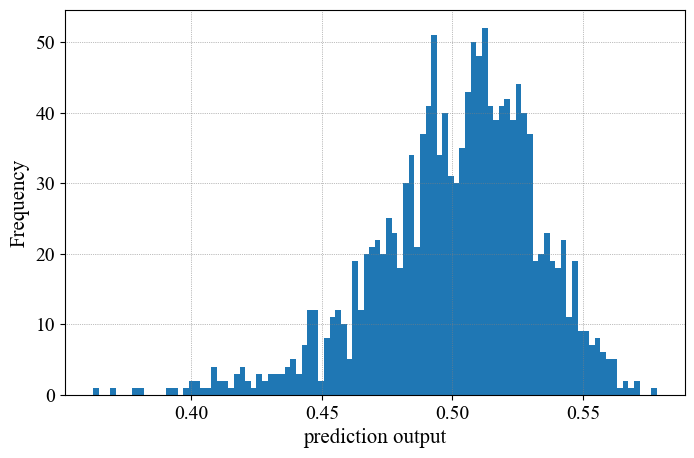

In [23]:
# Output distribution
pred_test.pred.plot.hist(bins=100, figsize=(8, 5))
plt.xlabel("prediction output")

display(
    "Fig.7: Distribution of model output in test sample",
    pred_test.pred.describe().to_frame("Raw Prediction Output").T,
    pred_test.pred_label.value_counts().to_frame("Prediction Label Count").T
)

### 6.2.2 Prediction quality

As shown in Table7, the AUC is 0.53, indicating a performance that surpasses random predictions and suggesting that the model has learned some form of pattern.  

Figure 8 displays a cumulative return graph for dates labeled as "Up".   
It consistently outperforms the strategy of maintaining a long position continuously, resulting in an Annualized Sharpe Ratio of approximately 1.0 (*transaction costs are not taken into account).  

'Table6: Classification Report'

              precision    recall  f1-score   support

         0.0       0.51      0.46      0.48       706
         1.0       0.52      0.57      0.54       718

    accuracy                           0.52      1424
   macro avg       0.52      0.51      0.51      1424
weighted avg       0.52      0.52      0.51      1424



'Table7: Prediction summary'

,up_signal_ratio,bce_loss,avg_pl,annu_sharpe,spearman_corr,auc
0,0.557584,0.690085,3.5099,1.038838,0.078998,0.534841


'Table8: Confusion Matrix'

,pred_false,pred_true
label_false,323,383
label_true,307,411


'Fig.8: Equity curve comparison'

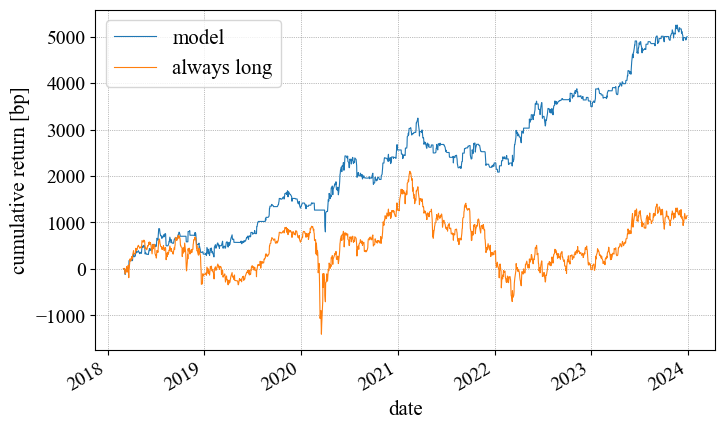

In [24]:
# Prediction quality
from sklearn.metrics import classification_report, confusion_matrix

display("Table6: Classification Report")    
print(classification_report(pred_test.label, pred_test.pred_label))

display(
    "Table7: Prediction summary",
    prediction_summary(pred_test),
    
    "Table8: Confusion Matrix",
    pd.DataFrame(
        confusion_matrix(pred_test.label, pred_test.pred_label),
        columns=["pred_false", "pred_true"],
        index=["label_false", "label_true"],
    ),
)

# PnL plot
display("Fig.8: Equity curve comparison")
pred_test.pl.cumsum().plot(ylabel="cumulative return [bp]", label="model", figsize=(8, 5))
label_ret.loc[pred_test.index.min():].cumsum().plot(label="always long")
plt.legend();

## 6.3 Strategy

### 6.3.1 Sizing strategy

In the previous discussion, we measured the performance of the strategy using only binary outputs (0 or 1), resulting in a Sharpe Ratio of approximately 1.03.   
One approach to improve this performance is to implement trade size adjustment logic based on the continuous model output values.

Table9 examines the relationship between the magnitude of the model's output values and the corresponding returns.   
It shows that as the model's output values increase, the returns also tend to increase.   
This suggests that increasing the trade size on days when the model's output values are larger may potentially lead to performance improvement.

In [25]:
display(
    "Table9: Return statistics by prediction level",
    pred_test
    .groupby(pd.cut(pred_test.pred, bins=np.arange(0, 1, 0.05)))
    .ret.agg(["count", "mean", "std"]).dropna().assign(**{"mean/std": lambda x: x["mean"] / x["std"]})
    .style.format(precision=2)
)

'Table9: Return statistics by prediction level'

,count,mean,std,mean/std
pred,,,,
"(0.35, 0.4]",7,-60.15,96.99,-0.62
"(0.4, 0.45]",84,-29.86,101.76,-0.29
"(0.45, 0.5]",539,-1.71,90.31,-0.02
"(0.5, 0.55]",747,5.76,70.89,0.08
"(0.55, 0.6]",47,14.73,84.36,0.17


To convert the model's output values on the test samples into a $PercentileSignal(t)$ within the range of [-1, 1].   
To avoid forward-looking, percentiles are determined using the validation sample.  
As indicated in Table10, the range and approximate distribution of validation output values align with those of the test output values.

In [26]:
display(
    "Table10: Prediction output distribution",
    pd.concat([
        pred_val.pred.describe().to_frame("valid").T,
        pred_test.pred.describe().to_frame("test").T,
    ]).rename(lambda x: f"sample: {x}")
)

'Table10: Prediction output distribution'

,count,mean,std,min,25%,50%,75%,max
sample: valid,208.0,0.496666,0.027823,0.385491,0.480896,0.496999,0.514715,0.570941
sample: test,1424.0,0.501174,0.030959,0.362356,0.483849,0.505331,0.522755,0.578180


\begin{equation}
    \begin{aligned}
    & PercentileSignal(t) := 2\cdot( P(output^{test}(t)) -0.5 )
    \end{aligned}
\tag{S1}
\end{equation}
(*Let $P$ as cumulative distribution function of model's output in validation sample, $output^{test}(t)$ as model's output in test sample.)

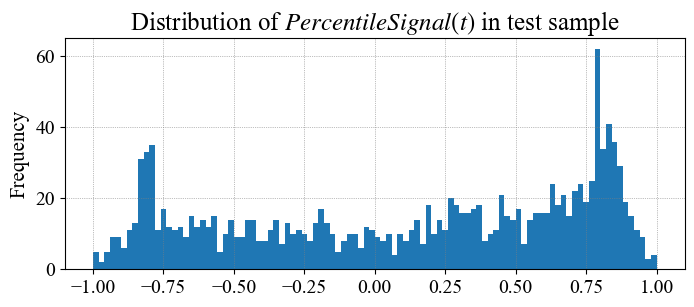

In [27]:
# Build quantile grid with validation output
from sklearn.preprocessing import QuantileTransformer
qtransform = QuantileTransformer(n_quantiles=10, random_state=7).fit(pred_val.pred.values.reshape(-1,1))
pred_test["pred_quantile"] = qtransform.transform(pred_test.pred.values.reshape(-1,1)).reshape(-1,)
pred_test["pred_quantile"] = pred_test.pred_quantile.sub(0.5).mul(2)

pred_test.pred_quantile.plot.hist(bins=100, figsize=(8, 3), title="Distribution of $PercentileSignal(t)$ in test sample");

In Figure 9, we have displayed the cumulative sum of returns weighted by $PercentileSignal(t)$ when $PercentileSignal(t)$, using only samples meeting this condition.   
When performance is measured using the Sharpe Ratio, we observe a slight improvement from 1.03 to 1.14, indicating a modest enhancement in performance.  

'Fig.9: Sizing strategy cumulative return (long only)'

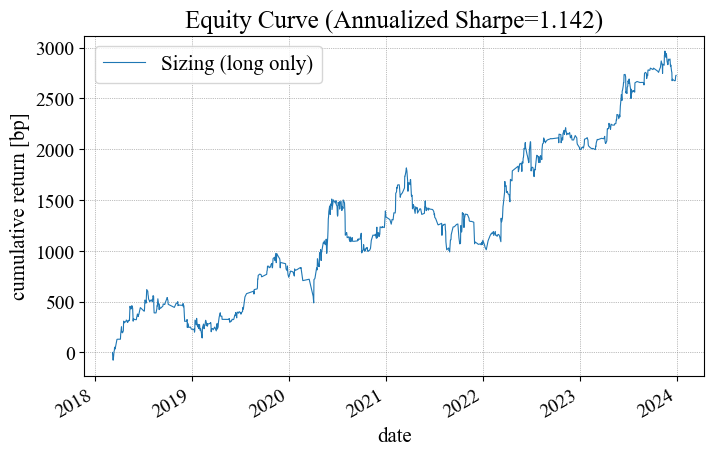

In [28]:
# Plot equity curve
pl = (pred_test.pred_quantile * pred_test.ret).loc[pred_test.pred_quantile > 0]

display(f"Fig.9: Sizing strategy cumulative return (long only)")
pl.cumsum().plot(
    figsize=(8, 5), 
    title=f"Equity Curve (Annualized Sharpe={round(calc_annu_sharpe(pl), 3)})", 
    ylabel="cumulative return [bp]", label="Sizing (long only)");
plt.legend();

### 6.3.2 Sizing strategy (allow short position)

In this scenario, short positions are allowed, which can enhance profit opportunities and potentially improve performance.   
Additionally, since the model's output has correlations in the negative direction, smaller output values indicate larger downward movements.   Therefore, the sizing logic is adapted for this purpose.

Figure 10 displays the cumulative sum of returns weighted by $PercentileSignal(t)$, allowing for short positions.   
The Sharpe Ratio increases to approximately 1.5, demonstrating an improvement of around 0.4 in performance.   
This change indicates that incorporating short positions and appropriate sizing logic can lead to enhanced performance.

"Fig.10: Sizing strategy's cumulative return (Annualized Sharpe=1.503)"

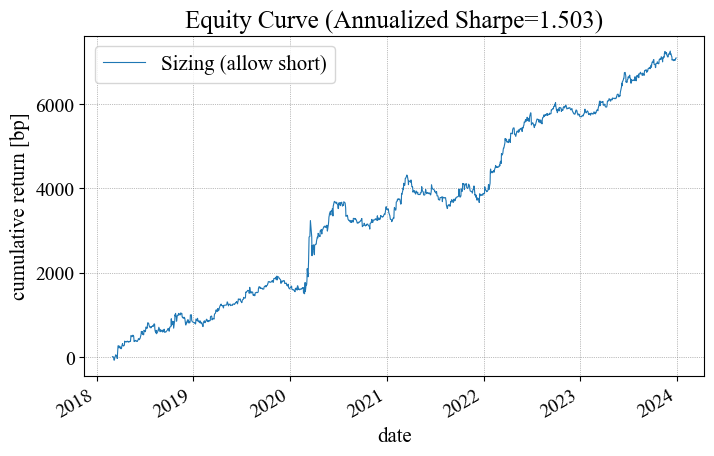

In [29]:
# Plot equity curve
pl = (pred_test.pred_quantile * pred_test.ret)

display(f"Fig.10: Sizing strategy's cumulative return (Annualized Sharpe={round(calc_annu_sharpe(pl), 3)})")
pl.cumsum().plot(
    figsize=(8, 5),
    title=f"Equity Curve (Annualized Sharpe={round(calc_annu_sharpe(pl), 3)})",
    ylabel="cumulative return [bp]", label="Sizing (allow short)"
);
plt.legend();

---

In [33]:
# !jupyter nbconvert "DL Takumi Arai REPORT.ipynb" --to html --template lab --HTMLExporter.theme dark

[NbConvertApp] Converting notebook DL Takumi Arai REPORT.ipynb to html
[NbConvertApp] Writing 2980750 bytes to DL Takumi Arai REPORT.html
